In [1]:
# periodic

import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os




2025-08-19 07:33:31.473810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-19 07:33:31.473836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-19 07:33:31.475067: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 07:33:31.482298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-19 07:33:33.806228: W tensorflow/compiler/tf2

In [2]:




cwd = os.getcwd()   # the current directory
print(cwd)






/global/u1/c/chen123/param_linear


$u_{tt} = k(w)u_{xx}, k(w) = c^2 \left(\sum_{l=1}^{4}\frac{1}{l^2}w_l\right)$

In [3]:
n_sample = 625
example_time_steps = 6
n_time_steps = 300
n_time_skip = 6


Nx = 200
N1 = Nx

L = 1.
c = .1
T = 1.23
K = 30


dx = L/Nx
dt = 0.01  # cfl = c*(dt/dx) ,c = sqrt(k(w)), k_max = 0.14246

x = np.arange(Nx)*dx
NNc = 11

# generate the parameters config
c2 = 0.1
w_all = np.linspace(0,1,5)
k_w = np.zeros((5,5,5,5))
for i in range(5):
    for j in range(5):
        for k in range(5):
            for p in range(5):
                k_w[i,j,k,p] = c2*(w_all[i]+w_all[j]/4+w_all[k]/9+w_all[p]/16)
k_w = k_w.reshape(-1,1)
                
                

def init(s):
    if s <= 1:
        return 1.-1.5*s**2.+0.75*s**3.
    elif 1<s<2:

        return 0.25*(2.-s)**3.
    return 0.


print(f'final time is {dt*n_time_steps}')
print(f'simulation time step is {dt}')
print(f'flow map time step is {dt*n_time_skip}')


Z = np.array([])

# loop for sample


vinit = np.vectorize(init)

# x0 = 0.5 + np.random.uniform(-0.2,0.2,size=n_sample)
# a0 = np.random.uniform(7.,9.,size=n_sample)
# w_all = np.random.uniform(1,2,size=n_sample)

z_list = []
p_list = []
q_list = []

for w in k_w:
    q = vinit(10*np.abs(x-0.5))
    p = np.zeros(N1, dtype=np.float64)
    z = np.concatenate([q, p], axis=0)

    z_list.append(z)
    p_list.append(p)
    q_list.append(q)

z = np.array(z_list) # convert list to numpy ndarray
p = np.array(p_list) # convert list to numpy ndarray
q = np.array(q_list) # convert list to numpy ndarray

# Z = z.copy()[np.newaxis,...]
Z_list = []
Z_list.append(z)

#print(p.shape)

final time is 3.0
simulation time step is 0.01
flow map time step is 0.06


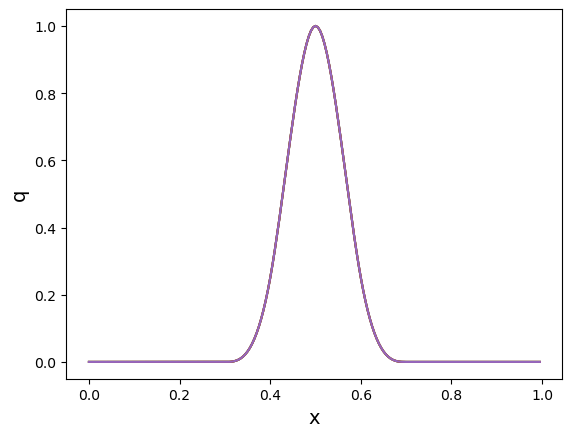

In [5]:
plt.figure()
# print(n_time_steps)
for i in range(0,5):

    plt.plot(x,q[i*10,:Nx])
plt.xlabel('x',fontsize=14)
plt.ylabel('q',fontsize=14)
plt.show()



In [6]:
for i in range(1,n_time_steps):


    q0 = q + 0.5*dt*p

    p = p + k_w*dt*(np.roll(q0,-1,axis=1) - 2.*q0 + np.roll(q0,1,axis=1))/dx**2.

    q = q0 + 0.5*dt*p;

    
    z = np.concatenate([q, p], axis=1)

    #ham[i] = 0.5*dx*np.dot(p,p) + c2*0.5/dx*(np.dot(q-np.roll(q,1),q-np.roll(q,1)))

    # Z = np.concatenate((Z, z[np.newaxis,...]))
    Z_list.append(z)

   

Z = np.array(Z_list)

print(Z.shape)



# # Z = Z[::n_time_skip,:,:]
Z = Z[::n_time_skip]
n_time_steps1 = Z.shape[0]


output_list = []
for shift in range(1, example_time_steps+1):
# output time series, starting from each single time step

    output_slice = Z[shift: n_time_steps1 - example_time_steps + shift]
# merge time and sample dimension as required by training
    n_time, _, n_x = output_slice.shape
    output_slice = np.reshape(output_slice, [n_sample * n_time, n_x])
    output_list.append(output_slice)

labels = np.stack(output_list, axis=1)

features = Z[:-example_time_steps,:,:]
features = features.reshape([n_time*n_sample,N1*2])







# the shape of input training data is (n_time, n_sample, n_x) or (n_time * n_sample, n_x)



(300, 625, 400)


In [7]:
Z.shape

(50, 625, 400)

In [8]:
k_w1 = np.repeat(k_w,repeats = 44, axis=1)


In [9]:
k_w1.shape

(625, 44)

In [ ]:
data_features = f"Wave_bump_peri_features_c_{c}_Nx_{N1}_sample_{n_sample}_timesteps_{n_time}_dt_{dt*n_time_skip*n_time_steps1}"
data_labels = f"Wave_bump_peri_labels_c_{c}_Nx_{N1}_sample_{n_sample}_timesteps_{n_time}_dt_{dt*n_time_skip*n_time_steps1}"


# ensure the data directory exists
data_dir = os.path.join(cwd, 'data')
os.makedirs(data_dir, exist_ok=True)  # create the data directory if it doesn't exist
features_file = os.path.join(cwd, "data", data_features + ".npy")
labels_file = os.path.join(cwd, "data", data_labels + ".npy")

print(data_features)

target_file = np.save(features_file, features)
target_file = np.save(labels_file, labels)

Wave_bump_peri_features_c_0.1_Nx_200_sample_625_timesteps_44_dt_3.0


In [17]:
if not os.path.exists(features_file):
    os.makedirs(features_file)
if not os.path.exists(labels_file):
    os.makedirs(labels_file)

In [11]:
target_file = np.save(data_features + ".npy",features)
target_file = np.save(data_labels + ".npy",labels)